TODO:

use transform to convert from np array to tensor (invert dimensions)

each file in labels should be an array, not an png 

change pothole rgb

In [1]:
!pip install yacs

In [2]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import numpy as np
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader



print(torch.__version__)

1.9.0+cu102


##Config

In [3]:

# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Ke Sun (sunk@mail.ustc.edu.cn)
# ------------------------------------------------------------------------------

from yacs.config import CfgNode as CN


_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True
_C.RANK = 0

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'seg_hrnet'
_C.MODEL.PRETRAINED = ''
_C.MODEL.ALIGN_CORNERS = True
_C.MODEL.NUM_OUTPUTS = 1
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.MODEL.PRETRAINED_LAYERS = ['*']
_C.MODEL.STEM_INPLANES = 64
_C.MODEL.FINAL_CONV_KERNEL = 1
_C.MODEL.WITH_HEAD = True

_C.MODEL.STAGE1 = CN()
_C.MODEL.STAGE1.NUM_MODULES = 1
_C.MODEL.STAGE1.NUM_BRANCHES = 1
_C.MODEL.STAGE1.NUM_BLOCKS = [4]
_C.MODEL.STAGE1.NUM_CHANNELS = [64]
_C.MODEL.STAGE1.BLOCK = 'BOTTLENECK'
_C.MODEL.STAGE1.FUSE_METHOD = 'SUM'

_C.MODEL.STAGE2 = CN()
_C.MODEL.STAGE2.NUM_MODULES = 1
_C.MODEL.STAGE2.NUM_BRANCHES = 2
_C.MODEL.STAGE2.NUM_BLOCKS = [4, 4]
_C.MODEL.STAGE2.NUM_CHANNELS = [32, 64]
_C.MODEL.STAGE2.BLOCK = 'BASIC'
_C.MODEL.STAGE2.FUSE_METHOD = 'SUM'

_C.MODEL.STAGE3 = CN()
_C.MODEL.STAGE3.NUM_MODULES = 1
_C.MODEL.STAGE3.NUM_BRANCHES = 3
_C.MODEL.STAGE3.NUM_BLOCKS = [4, 4, 4]
_C.MODEL.STAGE3.NUM_CHANNELS = [32, 64, 128]
_C.MODEL.STAGE3.BLOCK = 'BASIC'
_C.MODEL.STAGE3.FUSE_METHOD = 'SUM'

_C.MODEL.STAGE4 = CN()
_C.MODEL.STAGE4.NUM_MODULES = 1
_C.MODEL.STAGE4.NUM_BRANCHES = 4
_C.MODEL.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
_C.MODEL.STAGE4.NUM_CHANNELS = [32, 64, 128, 256]
_C.MODEL.STAGE4.BLOCK = 'BASIC'
_C.MODEL.STAGE4.FUSE_METHOD = 'SUM'

_C.MODEL.OCR = CN()
_C.MODEL.OCR.MID_CHANNELS = 512
_C.MODEL.OCR.KEY_CHANNELS = 256
_C.MODEL.OCR.DROPOUT = 0.05
_C.MODEL.OCR.SCALE = 1

_C.LOSS = CN()
_C.LOSS.USE_OHEM = False
_C.LOSS.OHEMTHRES = 0.9
_C.LOSS.OHEMKEEP = 100000
_C.LOSS.CLASS_BALANCE = False
_C.LOSS.BALANCE_WEIGHTS = [1]

# DATASET related params
_C.DATASET = CN()
_C.DATASET.ROOT = ''
_C.DATASET.DATASET = 'cityscapes'
_C.DATASET.NUM_CLASSES = 13
_C.DATASET.TRAIN_SET = 'list/cityscapes/train.lst'
_C.DATASET.EXTRA_TRAIN_SET = ''
_C.DATASET.TEST_SET = 'list/cityscapes/val.lst'

# training
_C.TRAIN = CN()

_C.TRAIN.FREEZE_LAYERS = ''
_C.TRAIN.FREEZE_EPOCHS = -1
_C.TRAIN.NONBACKBONE_KEYWORDS = []
_C.TRAIN.NONBACKBONE_MULT = 10

_C.TRAIN.IMAGE_SIZE = [1024, 512]  # width * height
_C.TRAIN.BASE_SIZE = 2048
_C.TRAIN.DOWNSAMPLERATE = 1
_C.TRAIN.FLIP = True
_C.TRAIN.MULTI_SCALE = True
_C.TRAIN.SCALE_FACTOR = 16

_C.TRAIN.RANDOM_BRIGHTNESS = False
_C.TRAIN.RANDOM_BRIGHTNESS_SHIFT_VALUE = 10

_C.TRAIN.LR_FACTOR = 0.1
_C.TRAIN.LR_STEP = [90, 110]
_C.TRAIN.LR = 0.01
_C.TRAIN.EXTRA_LR = 0.001

_C.TRAIN.OPTIMIZER = 'sgd'
_C.TRAIN.MOMENTUM = 0.9
_C.TRAIN.WD = 0.0001
_C.TRAIN.NESTEROV = False
_C.TRAIN.IGNORE_LABEL = -1

_C.TRAIN.BEGIN_EPOCH = 0
_C.TRAIN.END_EPOCH = 484
_C.TRAIN.EXTRA_EPOCH = 0

_C.TRAIN.RESUME = False

_C.TRAIN.BATCH_SIZE_PER_GPU = 32
_C.TRAIN.SHUFFLE = True
# only using some training samples
_C.TRAIN.NUM_SAMPLES = 0

# testing
_C.TEST = CN()

_C.TEST.IMAGE_SIZE = [2048, 1024]  # width * height
_C.TEST.BASE_SIZE = 2048

_C.TEST.BATCH_SIZE_PER_GPU = 32
# only testing some samples
_C.TEST.NUM_SAMPLES = 0

_C.TEST.MODEL_FILE = ''
_C.TEST.FLIP_TEST = False
_C.TEST.MULTI_SCALE = False
_C.TEST.SCALE_LIST = [1]

_C.TEST.OUTPUT_INDEX = -1

# debug
_C.DEBUG = CN()
_C.DEBUG.DEBUG = False
_C.DEBUG.SAVE_BATCH_IMAGES_GT = False
_C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
_C.DEBUG.SAVE_HEATMAPS_GT = False
_C.DEBUG.SAVE_HEATMAPS_PRED = False


In [87]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 0.005
batch_size = 8
num_epochs = 5
cur_epoch = 45
checkpoint_period = 1
valid_period = 1
resume_training = True

##HRNet


In [5]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Ke Sun (sunk@mail.ustc.edu.cn)
# ------------------------------------------------------------------------------

BN_MOMENTUM = 0.1
ALIGN_CORNERS = None
relu_inplace = True

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=relu_inplace)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        nn.BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=relu_inplace)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=ALIGN_CORNERS)
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        global ALIGN_CORNERS
        extra = config.MODEL
        super(HighResolutionNet, self).__init__()
        ALIGN_CORNERS = config.MODEL.ALIGN_CORNERS

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            nn.BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=relu_inplace),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config.DATASET.NUM_CLASSES,
                kernel_size=extra.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)

        # print()
        # print(x[0].shape)
        # print(x[1].shape)
        # print(x[2].shape)
        # print(x[3].shape)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        # print(x.shape)

        ph, pw = x.shape[2], x.shape[3]
        h, w = 288, 352

        final_x = None
        if ph != h or pw != w:
            final_x = F.interpolate(input=x, size=(
                h, w), mode='bilinear', align_corners=_C.MODEL.ALIGN_CORNERS)
        
        # print(final_x.shape)

        return final_x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d_class):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()              
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg.MODEL.PRETRAINED)

    return model


##Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!rm -rf /content/dataset/RTK/
!mkdir /content/dataset/
!mkdir /content/dataset/RTK/
!mkdir /content/dataset/RTK/pt_labels/
!cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/images/. /content/dataset/RTK/images/
!cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/labels/. /content/dataset/RTK/labels/

In [8]:
# check labels and images correspondence
from os import listdir
from os.path import isfile, join
import os
from skimage import io, transform


images_path = '/content/dataset/RTK/images'
images_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
images_names.sort()
# print(type(images_names))
# print(images_names)
print(len(images_names))

labels_path = '/content/dataset/RTK/labels'
labels_names = [f for f in listdir(labels_path) if isfile(join(labels_path, f))]
labels_names.sort()
print(len(labels_names))

images_names_set = set(images_names)
labels_names_set = set(labels_names)
in_img_n_lab = set()
in_lab_n_img = set()
for e in images_names_set:
  if e not in labels_names_set:
    in_img_n_lab.add(e)

for e in labels_names_set:
  if e not in images_names_set:
    in_lab_n_img.add(e)

print(len(in_img_n_lab))
print(len(in_lab_n_img))

732
732
0
0


In [35]:
# create tensor files based on labels
import cv2
pt_labels_path = '/content/dataset/RTK/pt_labels'
for label_name in labels_names:
  img =  cv2.imread(labels_path + '/' + label_name)
  tensor = torch.zeros([img.shape[0], img.shape[1]], dtype=torch.long)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      tensor[i][j] = img[i][j][0]
  torch.save(tensor, pt_labels_path + '/' + label_name[:-4] + '.pt')

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(image_name):
  img =  cv2.imread(images_path + '/' + image_name, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

In [37]:
color_map = {1:  (85,85,255),      # - HEX: #5555ff #roadAsphalt
             2:  (85,170,127),     # - HEX: #55aa7f #roadPaved
             3:  (255,170,127),    # - HEX: #ffaa7f #roadUnpaved
             4:  (255,255,255),    # - HEX: #ffffff #roadMarking
             5:  (255,85,255),     # - HEX: #ff55ff #speedBump
             6:  (255,255,127),    # - HEX: #ffff7f #catsEye    
             7:  (170,0,127),      # - HEX: #aa007f #stormDrain
             8 : (0,255,255),      # - HEX: #00ffff  #manholeCover
             9 : (0,0, 27),        # - HEX: #00007f #patchs
             10: (170,0,0),        # - HEX: #aa0000 #waterPuddle
             11: (255,0,0),        # - HEX: #ff0000 #pothole
             12: (255,85,0),       # - HEX: #ff5500 #cracks
             0:  (0,0,0),          # - HEX: #000000 #background
}

def show_label(label_name):
  img =  cv2.imread(labels_path + '/' + label_name)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      aa = img[i][j][0]
      bb = img[i][j][1]
      cc = img[i][j][2]
      if aa == bb and bb == cc:
        pass
      else:
        print("erro")
        assert False
      class_ = img[i][j][0]
      img[i][j][0] = color_map[class_][0]
      img[i][j][1] = color_map[class_][1]
      img[i][j][2] = color_map[class_][2]

  plt.imshow(img)

In [38]:
class RTKDataset(Dataset):
    def __init__(self, root_dir, ini, end, transform=None):
        self.root_dir = root_dir
        self.images_path = '/content/dataset/RTK/images'
        self.images_names = [f for f in listdir(self.images_path) if isfile(join(self.images_path, f))]
        self.images_names.sort()
        self.images_names = self.images_names[ini:end]

        self.labels_path = '/content/dataset/RTK/labels'
        self.labels_names = [f for f in listdir(self.labels_path) if isfile(join(self.labels_path, f))]
        self.labels_names.sort()
        self.labels_names = self.labels_names[ini:end]

        self.images_names_set = set(self.images_names)
        self.labels_names_set = set(self.labels_names)
        self.in_img_n_lab = set()
        self.in_lab_n_img = set()
        for e in self.images_names_set:
            if e not in self.labels_names_set:
              self.in_img_n_lab.add(e)

        for e in self.labels_names_set:
            if e not in self.images_names_set:
              self.in_lab_n_img.add(e)
        
        assert len(self.in_img_n_lab) == 0
        assert len(self.in_lab_n_img) == 0

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_path,
                                self.images_names[idx])
        image = io.imread(img_name)
        image = image.transpose((2, 0, 1))
        image = image / 255.
        image = torch.from_numpy(image)

        label =  torch.load(pt_labels_path + '/' + self.images_names[idx][:-3] + 'pt')
        sample = {'images': image, 'labels': label}
        return sample

532
200


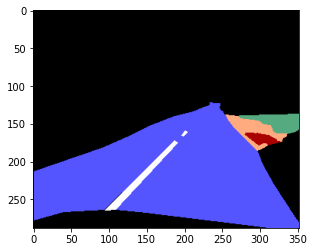

In [39]:
train_dataset = RTKDataset('/content/dataset/RTK', 0, 532)
valid_dataset   = RTKDataset('/content/dataset/RTK', 532, 732)
print(len(train_dataset))
print(len(valid_dataset))
show_label(train_dataset.images_names[0])

In [57]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

##Training

In [88]:
# Initialize network
print(_C.CUDNN)
# cudnn related setting
# cudnn.benchmark = _C.CUDNN.BENCHMARK
# cudnn.deterministic = _C.CUDNN.DETERMINISTIC
# cudnn.enabled = _C.CUDNN.ENABLED
# gpus = list(_C.GPUS)
# # distributed = args.local_rank >= 0
# # if distributed:
# device = torch.device('cuda:{}'.format(0))    
# torch.cuda.set_device(device)
# torch.distributed.init_process_group(backend="nccl", init_method="env://",rank=-1)      
model = HighResolutionNet(_C).double().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(device)
if resume_training:
  checkpoint = torch.load('/content/drive/Shareddrives/Carro Autonomo/HRNetTraining/hrnet/epoch_'+ str(cur_epoch-1) +'.pt', map_location=torch.device(device))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# ++++++++++++++++++++++Choose one++++++++++++++++++++++++++++
# model.eval()
# model.train()
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


BENCHMARK: True
DETERMINISTIC: False
ENABLED: True
cuda


In [89]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     788 MB |    7860 MB |   12171 GB |   12170 GB |
|       from large pool |     657 MB |    7720 MB |   12107 GB |   12106 GB |
|       from small pool |     130 MB |     159 MB |      64 GB |      63 GB |
|---------------------------------------------------------------------------|
| Active memory         |     788 MB |    7860 MB |   12171 GB |   12170 GB |
|       from large pool |     657 MB |    7720 MB |   12107 GB |

In [61]:
# Check accuracy on training & test to see how good our model
def check_valid_loss():
    model.eval()
    iter = 0
    losses = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(tqdm(valid_loader)):
            data    = sample['images']
            targets = sample['labels']
            data_gpu = data.to(device=device)
            targets_gpu = targets.to(device=device)

            # forward
            scores = model(data_gpu)
            loss = criterion(scores, targets_gpu)
            losses += loss
            iter += 1
    avg_loss = losses/iter
    model.train()
    return avg_loss

In [62]:
check_valid_loss()


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


tensor(0.7485, device='cuda:0', dtype=torch.float64)

In [ ]:
# Train Network
model_path = '/content/drive/Shareddrives/Carro Autonomo/HRNetTraining/hrnet/'
model.train()

for epoch in range(cur_epoch, cur_epoch + num_epochs):
    iter = 0
    losses = 0
    for batch_idx, sample in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data    = sample['images']
        targets = sample['labels']
        data_gpu = data.to(device=device)
        targets_gpu = targets.to(device=device)

        # forward
        scores = model(data_gpu)
        loss = criterion(scores, targets_gpu)
        losses += loss
        iter += 1

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    avg_loss = losses/iter
    print(avg_loss)
    
    if epoch % valid_period == 0:
        print(check_valid_loss())

    if epoch % checkpoint_period == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, model_path +'epoch_' + str(epoch) + '.pt')



100%|██████████| 67/67 [03:30<00:00,  3.14s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor(0.3024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)



100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


tensor(0.7676, device='cuda:0', dtype=torch.float64)



100%|██████████| 67/67 [03:30<00:00,  3.14s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor(0.3114, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)



100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


tensor(0.9970, device='cuda:0', dtype=torch.float64)



100%|██████████| 67/67 [03:30<00:00,  3.14s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor(0.2780, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)



100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


tensor(0.9879, device='cuda:0', dtype=torch.float64)



100%|██████████| 67/67 [03:30<00:00,  3.14s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor(0.2500, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)



100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


tensor(1.0457, device='cuda:0', dtype=torch.float64)



 30%|██▉       | 20/67 [01:03<02:28,  3.16s/it]

##Tests

torch.Size([1, 288, 352])


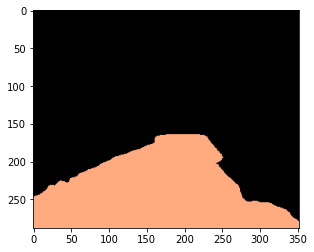

In [69]:
model.eval()
# print(train_dataset[0]['images'].unsqueeze(0).shape)
with torch.no_grad():
  scores = model(train_dataset[400]['images'].unsqueeze(0).to(device=device))
  _, predictions = scores.max(1)
  print(predictions.shape)

  img = np.zeros((predictions.shape[1], predictions.shape[2], 3), dtype=np.int)
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        class_ = predictions[0][i][j].item()
        img[i][j][0] = color_map[class_][0]
        img[i][j][1] = color_map[class_][1]
        img[i][j][2] = color_map[class_][2]

plt.imshow(img)

torch.Size([1, 288, 352])


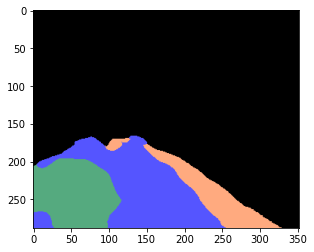

In [84]:
image_number = 280

model.eval()
with torch.no_grad():
  # print(train_dataset[0]['images'].unsqueeze(0).shape)
  scores = model(train_dataset[image_number]['images'].unsqueeze(0).to(device=device))
  _, predictions = scores.max(1)
  print(predictions.shape)

  img = np.zeros((predictions.shape[1], predictions.shape[2], 3), dtype=np.int)
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        class_ = predictions[0][i][j].item()
        img[i][j][0] = color_map[class_][0]
        img[i][j][1] = color_map[class_][1]
        img[i][j][2] = color_map[class_][2]

plt.imshow(img)

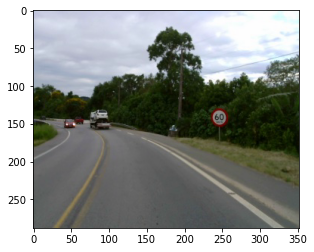

In [85]:
show_image(train_dataset.images_names[image_number])

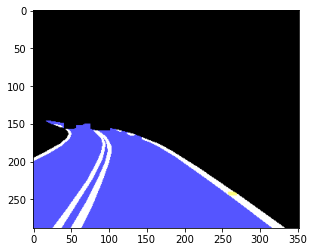

In [86]:
show_label(train_dataset.images_names[image_number])

##Nothing

In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.14
Accuracy on test set: 98.06


In [ ]:
# HRNet
BN_MOMENTUM = 0.1

class Stem(nn.Module):
  def __init__(self):
    super(Stem, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn1 = nn.SyncBatchNorm(64, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn2 = nn.SyncBatchNorm(64, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.SyncBatchNorm(planes, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.SyncBatchNorm(planes, momentum=BN_MOMENTUM)
    self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
    self.bn3 = nn.SyncBatchNorm(planes * self.expansion, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=relu_inplace)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out = out + residual
    out = self.relu(out)

    return out

class Stage1(nn.Module):
  def __init__(self):
    super(Stage, self).__init__()
    downsample = nn.Sequential( 
                  nn.Conv2d(64, 64 * 4, kernel_size=1, stride= 1, bias=False),
                  nn.SyncBatchNorm(64 * 4, momentum=BN_MOMENTUM),
                )
    self.bottleneck1 = Bottleneck(inplanes = 64, planes = 64, stride = 1, downsample)
    self.Bottleneck2 = Bottleneck(inplanes = 64 * 4, 64)
    self.Bottleneck3 = Bottleneck(inplanes = 64 * 4, 64)
    self.Bottleneck4 = Bottleneck(inplanes = 64 * 4, 64)

  def forward(self, x):
    x = self.bottleneck1(x)
    x = self.bottleneck2(x)
    x = self.bottleneck3(x)
    x = self.bottleneck4(x)
    return x

# class Stage(nn.Module):
#   def __init__(self, stage, num_modules, num_branches, num_blocks, num_channels):
#     super(Stage, self).__init__()

#     modules = []
#     for i in range(num_modules):
#       modules.append(
#           HighResolutionModule(num_branches,
#                                 block,
#                                 num_blocks,
#                                 num_inchannels,
#                                 num_channels,
#                                 True)
#       )
#       self.num_inchannels = modules[-1].get_num_inchannels()
#       self.stage = nn.Sequential(*modules)

#   def forward(self, x):
#     x = self.bottleneck1(x)
#     x = self.bottleneck2(x)
#     x = self.bottleneck3(x)
#     x = self.bottleneck4(x)
#     return x


class HRNet(nn.Module):
  def __init__(self):
    super(HRNet, self).__init__()
    self.stem = Stem()
    self.stage1 = Stage1()
    stage1_out_channel = block.expansion*num_channels

    num_channels = self.stage2_cfg['NUM_CHANNELS']
    block = blocks_dict[self.stage2_cfg['BLOCK']]
    num_channels = [
        num_channels[i] * block.expansion for i in range(len(num_channels))]
    self.transition1 = self._make_transition_layer(
        [stage1_out_channel], num_channels)
    self.stage2, pre_stage_channels = self._make_stage(
        self.stage2_cfg, num_channels)

    self.stage3_cfg = extra['STAGE3']
    num_channels = self.stage3_cfg['NUM_CHANNELS']
    block = blocks_dict[self.stage3_cfg['BLOCK']]
    num_channels = [
        num_channels[i] * block.expansion for i in range(len(num_channels))]
    self.transition2 = self._make_transition_layer(
        pre_stage_channels, num_channels)
    self.stage3, pre_stage_channels = self._make_stage(
        self.stage3_cfg, num_channels)

    self.stage4_cfg = extra['STAGE4']
    num_channels = self.stage4_cfg['NUM_CHANNELS']
    block = blocks_dict[self.stage4_cfg['BLOCK']]
    num_channels = [
        num_channels[i] * block.expansion for i in range(len(num_channels))]
    self.transition3 = self._make_transition_layer(
        pre_stage_channels, num_channels)
    self.stage4, pre_stage_channels = self._make_stage(
        self.stage4_cfg, num_channels, multi_scale_output=True)

  def _make_stage(self, num_modules, num_branches, num_blocks, num_channels):
    modules = []
    for i in range(num_modules):
      modules.append(
        HighResolutionModule(num_branches,
                              block,
                              num_blocks,
                              num_inchannels,
                              num_channels,
                              True)
      )

    num_inchannels = modules[-1].get_num_inchannels()
    return nn.Sequential(*modules), num_inchannels
  
  def _make_transition_layer(self, num_channels_pre_layer, num_channels_cur_layer):
    num_branches_cur = len(num_channels_cur_layer)
    num_branches_pre = len(num_channels_pre_layer)

    transition_layers = []
    for i in range(num_branches_cur):
      if i < num_branches_pre:
        if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
          transition_layers.append(nn.Sequential(
            nn.Conv2d(num_channels_pre_layer[i],
                      num_channels_cur_layer[i],
                      3,
                      1,
                      1,
                      bias=False),
                    BatchNorm2d(num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                    nn.ReLU(inplace=relu_inplace)))
        else:
          transition_layers.append(None)
      else:
        conv3x3s = []
        for j in range(i+1-num_branches_pre):
          inchannels = num_channels_pre_layer[-1]
          outchannels = num_channels_cur_layer[i] if j == i-num_branches_pre else inchannels
          conv3x3s.append(nn.Sequential(
            nn.Conv2d(inchannels, outchannels, 3, 2, 1, bias=False),
            BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=relu_inplace)))
        transition_layers.append(nn.Sequential(*conv3x3s))

    return nn.ModuleList(transition_layers)


  def forward(self, x):
    return x

SyntaxError: ignored

In [ ]:
# Simple CNN
class Conv_and_pool(nn.Module):
    def __init__(self):
      super(Conv_and_pool, self).__init__()
      self.conv1 = nn.Conv2d(
          in_channels=1,
          out_channels=8,
          kernel_size=(3, 3),
          stride=(1, 1),
          padding=(1, 1),
      )
      self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv_and_pool = Conv_and_pool();
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv_and_pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x



In [ ]:
# Load Data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
